In [1]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
import matplotlib
import folium
import warnings
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
%matplotlib inline

In [2]:
df_raw = pd.read_csv('data/tx_ev_registrations_public.csv')

In [3]:
years = pd.DataFrame(df_raw['Registration Valid Date'].value_counts().reset_index().values, columns=["Year", "Registered Vehicles"])

,Registered Vehicles
Year,
2019-11-01,211.0
2019-11-02,2.0
2019-11-03,5.0
2019-11-04,23.0
2019-11-05,23.0
...,...
2022-06-28,279.0
2022-06-29,276.0
2022-06-30,232.0


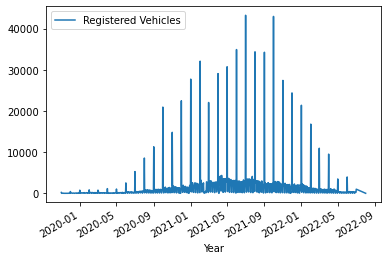

In [4]:
df = pd.DataFrame(years['Registered Vehicles'])
df = df.set_axis(pd.to_datetime(years['Year']))
df.plot()
df = df.sort_values(by=['Year'], ascending = True)
df = df.astype(float)
df

## **RESAMPLING

In [5]:
# # Interpolate - Backfill 
# df = df.resample('W').interpolate(method = 'linear')
# df = df.bfill()
# print(df.head())
# df.plot()

In [6]:
# # Backfill 
# df = df.resample('W').bfill()
# df.plot()

<AxesSubplot:xlabel='Year'>

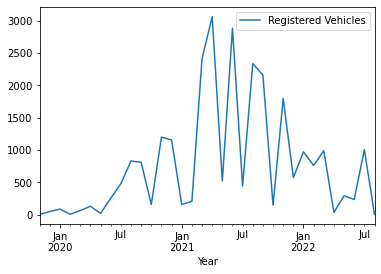

In [7]:
# #Frontfill 
df = df.resample('M').ffill()
df.plot()

## Testing 

In [8]:
adtest = adfuller(df)
display(adtest)

(-4.619709427736718,
 0.00011878544943994375,
 0,
 33,
 {'1%': -3.6461350877925254,
  '5%': -2.954126991123355,
  '10%': -2.6159676124885216},
 384.01011825980726)

## Modeling

In [20]:
# Splitting Training and Testing data; using after 2019 as test

train = df['2017-06-30':'2021-12-31']
test = df['2022-01-31':]
combined = df

train

,Registered Vehicles
Year,
2019-11-30,3.0
2019-12-31,46.0
2020-01-31,84.0
2020-02-29,4.0
2020-03-31,61.0
2020-04-30,128.0
2020-05-31,17.0
2020-06-30,252.0
2020-07-31,477.0


In [28]:
auto_model = pm.auto_arima(train, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_model.summary())



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=447.534, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=440.638, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=444.583, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=436.441, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=433.964, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=435.859, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=435.559, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=434.271, Time=0.07 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=437.546, Time=0.13 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=434.175, Time=0.07 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 0.588 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   26
Model:               SARIMAX(3, 0, 0)   Log Likelihood                -2

### The best model is :  ARIMA (3,0,0) (0,0,0) [0]

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0895      0.167      0.535      0.593      -0.239       0.418
ar.L2          0.3662      0.195      1.879      0.060      -0.016       0.748
ar.L3          0.4385      0.197      2.229      0.026       0.053       0.824
sigma2       8.17e+05   2.47e+05      3.306      0.001    3.33e+05     1.3e+06


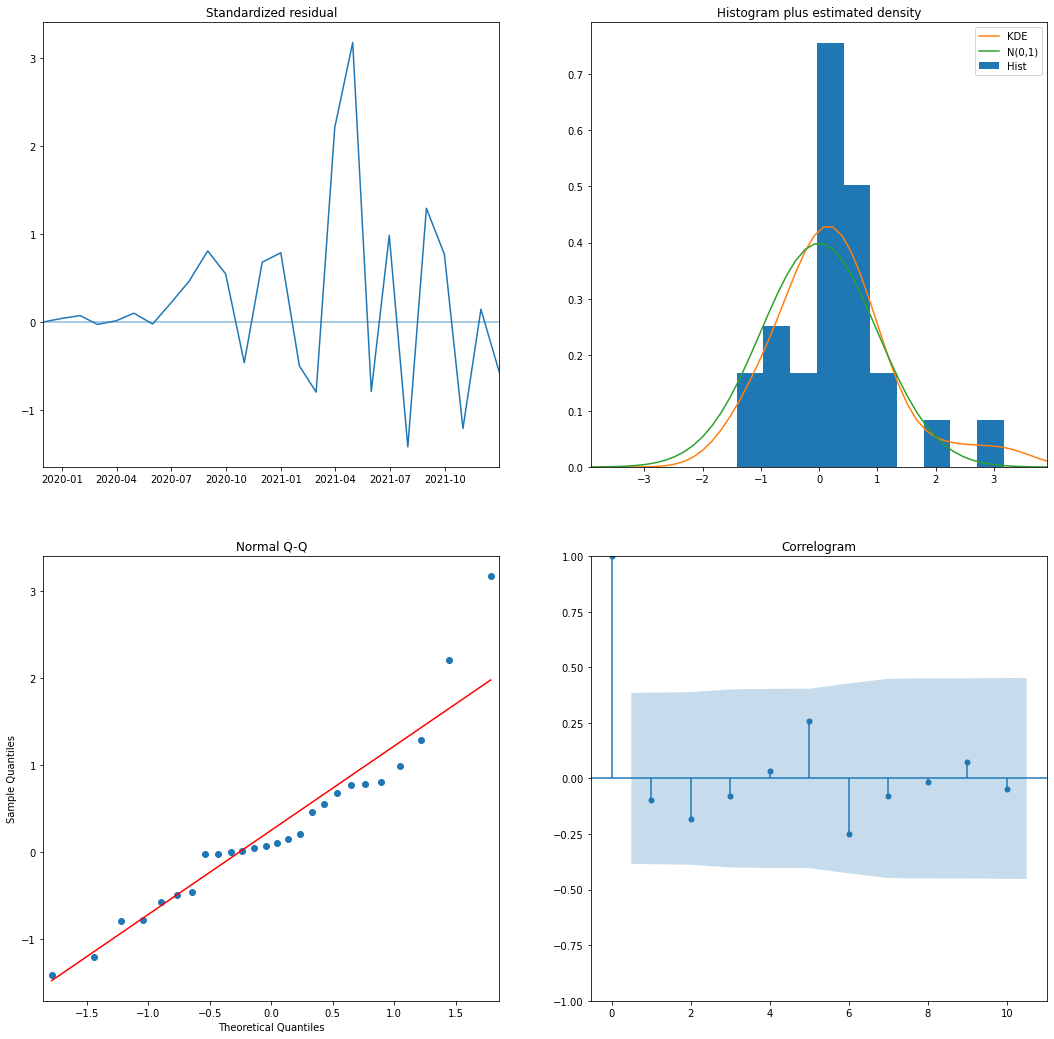

In [22]:
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(train, 
                                        order=(3,0,0), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

In [23]:
pred = output.get_prediction(start=pd.to_datetime('2020-12-31'), end=pd.to_datetime('2022-08-31'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf

,lower Registered Vehicles,upper Registered Vehicles
2020-12-31,-1254.098368,2288.940328
2021-01-31,-1162.506271,2380.532425
2021-02-28,-810.526868,2732.511828
2021-03-31,-1190.951871,2352.086825
2021-04-30,-1413.712454,2129.326242
2021-05-31,-526.846393,3016.192303
2021-06-30,451.668564,3994.707260
2021-07-31,18.557177,3561.595873
2021-08-31,-449.343608,3093.695088
2021-09-30,-137.107442,3405.931255


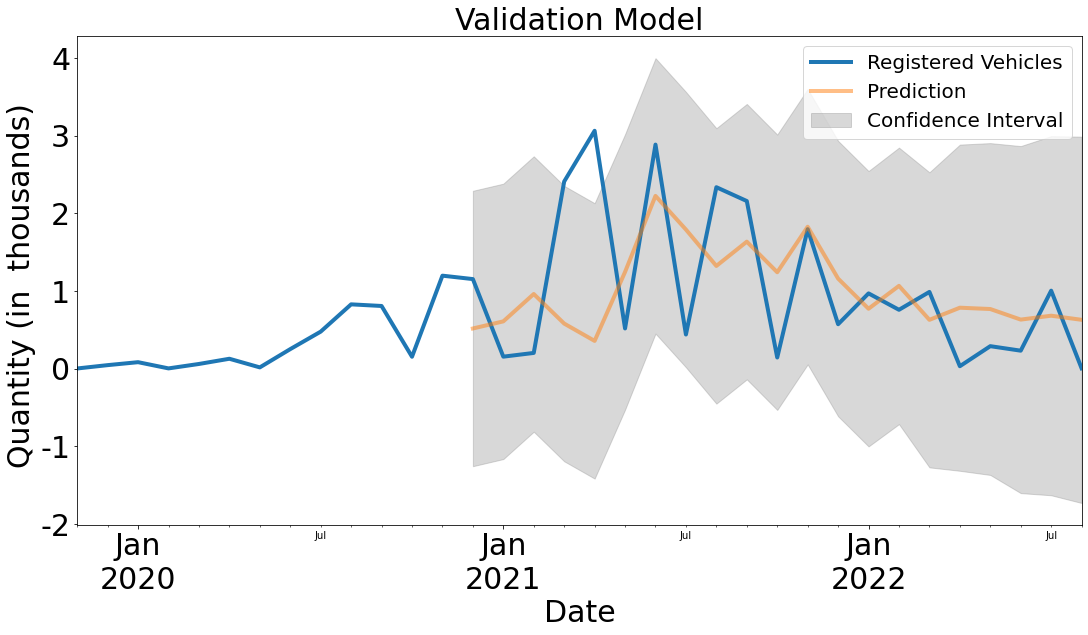

In [27]:


rcParams['figure.figsize'] = 18, 9
ax = df.plot(label='observed', linewidth = 4)

pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.5, linewidth = 4)


ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='grey', alpha=0.3,label = 'Confidence Interval')


ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=30)
ax.set_ylabel('Quantity (in  thousands) ',fontsize=30)
plt.yticks(fontsize=30)
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Validation Model',fontsize=30)
plt.legend(fontsize = 20)

plt.show()